In [153]:
import os

import numpy as np
import pandas as pd
import dvwtools.read as dv
import dvwtools.stats as dvstats
from BaseFunctionsDef import *
from IPython.core.display import display
import base64
import importlib
from IPython.display import Image
import plotly.graph_objects as go
import plotly.express as px

importlib.reload(dvstats)
importlib.reload(dv)

pd.set_option('max_columns', None)
pd.set_option('mode.chained_assignment', 'raise')



In [154]:
# Loads the image of the volleyball court
path_image = os.path.join("assets", "mezzoCampo_up.png")
path_image_set = os.path.join("assets", "mezzoCampo.png")

# Just some handling of the volleyball court image
encoded_image_up = base64.b64encode(open(path_image, 'rb').read())
encoded_image_down = base64.b64encode(open(path_image_set, 'rb').read())

In [155]:
parquet_path = os.path.join('datasets', 'dataParquet')
df_rosters = pd.read_parquet('datasets/dataParquet/rosters.parquet')
df = pd.read_parquet(os.path.join(parquet_path, 'complete_df.parquet.gzip'))
df_pass = dv.get_reception_df(df)
teams_list = pd.read_parquet(os.path.join(parquet_path, 'teams.parquet.gzip'))
giocatori_list = pd.read_parquet(os.path.join(parquet_path, 'players.parquet.gzip'))



df_pass = df_pass.merge(df_rosters[['code', 'height', 'birthdate']], how='left', left_on='SideoutAttackCodiceGiocatore', right_on='code')
now = pd.to_datetime('now')
df_pass['age'] = (now - df_pass['birthdate']).astype('<m8[Y]')

In [156]:
keep_cols = ['SquadraNome', 'Partita', 'Competizione', 'Round', 'Date', 'TeamAvvName', 'PuntiInt', 'PuntiOsp', 'currentset',
            'iz', 'az',
             'ServeGiocatoreName', 'x_p', 'y_p',
             'GiocatoreName', 'valutazione',  'x_a', 'y_a', 'CurrentPlayerPosition',
             'SecondTouchGiocatoreName', 'SecondTouchGrade', 'SecondTouchX_start',
             'SecondTouchY_start', 'SecondTouchCall', 'SecondTouchServito',
             'SideoutAttackGiocatoreName', 'SideoutAttackGrade',
             'SideoutAttackX_start', 'SideoutAttackY_start',
             'IsRallyWon', 'IsSetWon', 'IsMatchWon', 'age', 'height']

df_clear = df_pass[keep_cols]
df_clear.columns = keep_cols

df_clear = df_clear.rename(columns=
    {'SquadraNome': 'team_name',
     'Partita': 'game_name',
     'Competizione': 'competition',
     'Round': 'round',
     'Date': 'date',
     'TeamAvvName': 'opponent_team',
     'PuntiInt': 'score_home',
     'PuntiOsp': 'score_guest',
     'currentset': 'current_game',
     'valutazione': 'reception_quality',
     'GiocatoreName': 'reception_player',
     'CurrentPlayerPosition': 'reception_player_position',
     'iz': 'rotation_home',
     'az': 'rotation_guest',
     'x_p': 'serve_x',
     'y_p': 'serve_y',
     'x_a': 'reception_x',
     'y_a': 'reception_y',
     'ServeGiocatoreName': 'serve_player',
     'SecondTouchGiocatoreName': 'set_player',
     'SecondTouchGrade': 'set_quality',
     'SecondTouchX_start': 'set_x',
     'SecondTouchY_start': 'set_y',
     'SideoutAttackGiocatoreName': 'attack_player',
     'SideoutAttackGrade': 'attack_quality',
     'SideoutAttackX_start': 'attack_x',
     'SideoutAttackY_start': 'attack_y',
     'SecondTouchCall': 'call',
     'SecondTouchServito': 'attacker'
     }
)

quality = ['#', '+', '!', '-', '/', '=']
setter_quality = ['#', '+', '!', '-', '/', '=', 'No Set']
atk_quality = ['#', '+', '!', '-', '/', '=', 'No Attack']
df_clear.reception_quality = df_clear.reception_quality.astype(pd.CategoricalDtype(quality, ordered=True))
df_clear.set_quality = df_clear.set_quality.astype(pd.CategoricalDtype(setter_quality, ordered=True))
df_clear.attack_quality = df_clear.attack_quality.astype(pd.CategoricalDtype(atk_quality, ordered=True))
df_clear = df_clear.assign(IsSideoutPoint=[True if val == '#' else False for val in df_clear.attack_quality])




# Analysis of Women's Volleyball sideout performance in year 2021
### November 2021
#### Andrea Biasioli

<br><br><br>

# Index
- [Main objective](#objective)
- [Introduction to the dataset](#intro)
- [Data cleaning](#cleaning)
- [Data preparation](#prep)
- [Data exploration](#exploration)
> [1. Correlations and linear relationship<br>](#correlations)
> [2. Numerical variables distribution<br>](#correlations)
- [Preprocessing pipeline](#pipeline)
- [Training-test split](#qualityset)
- [Output variable processing](#output)
- [Dummy predictor](#dummy)
- [Vanilla linear regression](#vanilla)
> [1. Important features<br>](#features_vanilla)
> [2. k-fold validation<br>](#kfold)
> [3. Polynomial features<br>](#poly)
> [4. Polynomial features (only interaction terms)<br>](#interactions)
- [Ridge linear regression](#ridge)
- [Lasso linear regression](#lasso)
- [ElasticNet linear regression](#elastic)
- [Visualization of residuals](#residuals)
- [Summary of the trained models](#summary)
- [Model selection](#modelchoice)
- [Key findings summary](#keyfindings)
- [Conclusions](#conclusions)
- [Future plans and suggestions](#future)

<br><br>

<br><br>


<a id='objective'></a>

# Main objective

The model will focus on *interpreting* the effect of different variables on the outcome.
The outcome for this model is the efficiency of the first attack after reception (more clear after the intro to the dataset).

<br><br>


<a id='intro'></a>


# Introduction to the dataset
The dataset was introduced in the previous course. Please see the details [here](https://andrea-intro-to-volleyball.herokuapp.com/#dataset).

The dataset contains many more categorical than numerical attributes, as such it is more suitable to *classification* questions.

After an initial data preparation for machine learning, for this analysis we are going to use an aggregation of the original dataset. The aggregation will contain numerical features that we will model.

A look into three rows of the dataset:

In [157]:
display(df_clear.sample(3))

,team_name,game_name,competition,round,date,opponent_team,score_home,score_guest,current_game,rotation_home,rotation_guest,serve_player,serve_x,serve_y,reception_player,reception_quality,reception_x,reception_y,reception_player_position,set_player,set_quality,set_x,set_y,call,attacker,attack_player,attack_quality,attack_x,attack_y,IsRallyWon,IsSetWon,IsMatchWon,age,height,IsSideoutPoint
5810,Turkey,07/31/2021 2020 Tokyo Olympics ARG-TUR 0-3,2020 Tokyo Olympics,Qualification Round,2021-07-31,Argentina,0,1,3,1,1,Mayer Victoria,63,5,Ismailoglu Meliha,+,26,75,OH1,Aydemir Akyol Naz,#,69.0,46.0,K1,F,Karakurt Ebrar,=,16.0,46.0,False,True,True,21.0,196.0,False
3049,Serbia,07/29/2021 2020 Tokyo Olympics SRB-KEN 3-0,2020 Tokyo Olympics,Qualification Round,2021-07-29,Kenya,2,1,2,1,1,Mercy Moim,76,4,Popovic Silvija,-,50,79,L,Ognjenovic Maja,#,48.0,30.0,KO,F,Boškovic Tijana,-,13.0,43.0,True,True,True,24.0,193.0,False
14775,Brazil,06/07/2021 VNL 2021 BEL-BRA 0-3,VNL 2021,Week 3,2021-06-07,Belgium,11,6,2,6,6,Janssens Marlies,22,3,Brait Camila,#,62,78,L,Silva Carneiro Macris Fernanda,#,61.0,45.0,K7,B,Caixeta Tandara,#,83.0,43.0,True,True,True,33.0,184.0,True


<br>
The dataset now includes sideout data related also to other teams (not only Team USA).


Some additional features are included:
- *team_name* (string): the name of the sideout team (remember each row represent one sideout instance)
- *game_name* (string): the name of the current game
- *call* (string): the [call](https://marklebedew.com/2021/09/06/setter-call-analysis-2021-olympics) for the middle blocker
- *attacker* (string): an ID for the attacker position (front, back, pipe, center, setter)
- *height* (float): attacker height in centimeters
- *age* (float): attacker age in years

Let's review some of the attributes that we are going to aggregate on.

<br><br>

## Attack quality score
[As previously seen](https://andrea-intro-to-volleyball.herokuapp.com/#quality), the *attack_quality* attribute is an ordered categorical.

It is certainly possible to convert it using an *OrdinalEncoder*, however, the categories are not equally spaced and equally "worth".

I will look at the overall dataset-wide statistics on *IsRallyWon* to establish weights for each *attack_quality* category.

In [158]:
atk_score_df = pd.pivot_table(df_clear, index='attack_quality', columns='IsRallyWon', aggfunc='size').reset_index()
atk_score_df = atk_score_df.rename(columns={True: 'Win', False: 'Lost'})
atk_score_df.columns.name = None
atk_score_df['Total'] = atk_score_df.Win + atk_score_df.Lost
atk_score_df['quality_score'] = atk_score_df.Win / atk_score_df.Total
display(atk_score_df)

map_atk = pd.Series(atk_score_df.quality_score.values, index=atk_score_df.attack_quality.values)


,attack_quality,Lost,Win,Total,quality_score
0,#,0,8607,8607,1.000000
1,+,448,787,1235,0.637247
2,!,475,750,1225,0.612245
...,...,...,...,...,...
4,/,1425,0,1425,0.000000
5,=,1349,0,1349,0.000000
6,No Attack,2571,462,3033,0.152324


The new feature *quality_score* goes from 0 (direct point for the opponent team) to 1 (direct point for the home team).

The middle-ground categories score shows how frequently the team won the rally after a sideout attack of the specified *attack_quality*.

Example: a '+' attack is only marginally better than a '!' attack, with a rally success rate of 63.7% for the former. With a '+' sideout attack, the attacking team generally won the rally 63.7% of the times.

Interestingly, not attacking is associated with better outcomes with respect to attack errors '=' or blocked attack '/'.

<br><br>

## Reception quality score

[Similarly](https://andrea-intro-to-volleyball.herokuapp.com/#quality), also reception quality score can be weighted based on the rally outcomes.

The *quality_score* is bound from 0 (opponent scoring) to 1 (home team scoring).

The worst reception outcome '=' leads to a direct point for the opponent team, a service ace, resulting in a score of 0.

However, the best reception outcome does not grant a direct point for the sideout team: in this case, it does so only 68.3% of the times.
This means that while potentially the *quality_score* maximum value is 1 (all '#' reception_quality resulting in a won rally), practically the value is <1.


In [159]:
pass_score_df = pd.pivot_table(df_clear, index='reception_quality', columns='IsRallyWon', aggfunc='size').reset_index()
pass_score_df = pass_score_df.rename(columns={True: 'Win', False: 'Lost'})
pass_score_df.columns.name = None
pass_score_df['Total'] = pass_score_df.Win + pass_score_df.Lost
pass_score_df['quality_score'] = pass_score_df.Win / pass_score_df.Total
display(pass_score_df)
map_pass = pd.Series(pass_score_df.quality_score.values, index=pass_score_df.reception_quality.values)


,reception_quality,Lost,Win,Total,quality_score
0,#,1588,3443,5031,0.684357
1,+,2633,4947,7580,0.652639
2,!,1494,2339,3833,0.610227
3,-,2074,2323,4397,0.528315
4,/,836,336,1172,0.286689
5,=,1400,0,1400,0.000000


In [160]:
df_clear['reception_quality_index'] = df_clear['reception_quality'].map(map_pass).astype(float)
df_clear['attack_quality_index'] = df_clear['attack_quality'].map(map_atk).astype(float)


<a id='cleaning'></a>

<br><br>

# Data exploration and data cleaning

In my aggregation, I will need *set_x*, *set_y*, and *attacker* attributes. Let's verify whether this attributes are 'clean'.


In [161]:
print(f'Total no. of rows: {len(df_clear)}\n')

Total no. of rows: 23413



<br><br>

## set_x and set_y
Usually null values for set_x and set_y are bundled together.
The analysis below tells that 2547 rows have null set coordinates. That's 12% of rows!

While that is not a negligible result, the missing coordinates coincide with missing set_quality (or better, 'No Set' is present after the reception). However, after some receptions (namely all the '=' and most of the '/' *reception_quality* receptions) it is *expected* that no set is present.

This tells us that those 'missing' features are indeed expected and belong there (while being a nuisance for the calculations anyway).

The anomalies (missing set_x and set_y with *reception_quality' of '+' and '-') constitute only 0.14% of the available rows. While it is difficult with the available information to establish the specific reason behind this missing info, it is likely unimportant given the size of the dataset.

(Optional additional info: it is possible that also with *reception_quality' of '+' and '-' there could be some legitimate missing values. This would be the case for rare events such as net infractions and others.)

<br>


In [162]:
find_no_set_coordinates = df_clear.set_x.isna()
print(f'Missing set_x rows: \n{find_no_set_coordinates.value_counts()}\n\n')

find_no_set_coordinates = df_clear.set_y.isna()
print(f'Missing set_y rows: \n{find_no_set_coordinates.value_counts()}\n\n')

find_no_set_coordinates = df_clear.set_quality == 'No Set'
print(f'Missing set_quality rows: \n{find_no_set_coordinates.value_counts()}\n\n')

find_no_set_coordinates = df_clear.set_y.isna()
print(f'Missing set_y rows, looking at reception_quality: \n{df_clear["reception_quality"].loc[find_no_set_coordinates].value_counts()}\n\n')


# display(df_clear[(find_no_set_coordinates) & (df_clear['reception_quality'].isin(['-', '+']))].sample(5))

Missing set_x rows: 
False    20866
True      2547
Name: set_x, dtype: int64


Missing set_y rows: 
False    20866
True      2547
Name: set_y, dtype: int64


Missing set_quality rows: 
False    20866
True      2547
Name: set_quality, dtype: int64


Missing set_y rows, looking at reception_quality: 
=    1397
/    1120
-      28
+       2
#       0
!       0
Name: reception_quality, dtype: int64




Let's now check for invalid set_x and set_y rows (invalid is defined as value equal to -1 for this dataset).

The invalid values account for 1.5% of the values. These are not negligible, and should be ideally be corrected directly at the source of the data.

For this analysis, the invalid values are going to be replaced with the mean values of the column, while the null values are going to be left unaltered (as they are physically representative).




In [163]:
find_no_set_coordinates = df_clear.set_x == -1
print(f'Invalid set_x rows: \n{find_no_set_coordinates.value_counts()}\n\n')

find_no_set_coordinates = df_clear.set_y == -1
print(f'Invalid set_y rows: \n{find_no_set_coordinates.value_counts()}\n\n')

missing_set = df_clear[find_no_set_coordinates]

# display(missing_set.game_name.value_counts().to_frame())
# missing_set.to_csv('temp/missing_set_coord.csv')
#
# find_no_set_coordinates = df_clear.attack_quality == 'No Attack'
# print(f'Missing attack_quality rows: \n{find_no_set_coordinates.value_counts()}\n\n')


Invalid set_x rows: 
False    23063
True       350
Name: set_x, dtype: int64


Invalid set_y rows: 
False    23062
True       351
Name: set_y, dtype: int64




In [164]:
mean_x = df_clear['set_x'].loc[df_clear.set_x > -1].mean()
mean_y = df_clear['set_y'].loc[df_clear.set_y > -1].mean()
df_clear.loc[df_clear.set_y == -1, 'set_y'] = mean_y
df_clear.loc[df_clear.set_x == -1, 'set_x'] = mean_x

find_no_set_coordinates = df_clear.set_x == -1
print(f'Invalid set_x rows: \n{find_no_set_coordinates.value_counts()}\n\n')

find_no_set_coordinates = df_clear.set_y == -1
print(f'Invalid set_y rows: \n{find_no_set_coordinates.value_counts()}\n\n')



Invalid set_x rows: 
False    23413
Name: set_x, dtype: int64


Invalid set_y rows: 
False    23413
Name: set_y, dtype: int64




In [165]:
## Attacker


# display(df_clear.attacker.value_counts())
# display(df_clear.attacker.isna().value_counts())
#

<br><br>

## Age

The distribution of the age of the attackers, right skewed. The only missing values are when no sideout attack is present (which is expected).

No Attacker            3033
Lazareva Anna             0
Ogoms Alicia              0
                       ... 
Goncharova Nataliya       0
Gocanin Bojana            0
Larson Jordan             0
Name: attack_player, Length: 321, dtype: int64

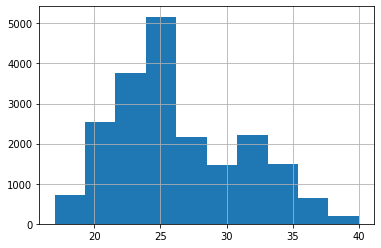

In [166]:
df_clear.age.hist()

display(df_clear.loc[df_clear.age.isna(), 'attack_player'].value_counts())

<br><br>

## Height

Height of the attackers, slightly left-skewed. Once again, the values missing are in corrispondence of 'No Attack' situations.

No Attacker            3033
Lazareva Anna             0
Ogoms Alicia              0
                       ... 
Goncharova Nataliya       0
Gocanin Bojana            0
Larson Jordan             0
Name: attack_player, Length: 321, dtype: int64

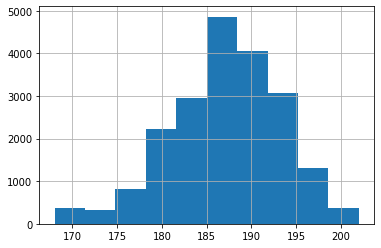

In [167]:
df_clear.height.hist()
display(df_clear.loc[df_clear.height.isna(), 'attack_player'].value_counts())

<br><br>

<a id='prep'></a>

# Data preparation: aggregated dataset for linear regression

As the dataset contains many categorical features, it is not suitable for regressions (numerical).

Therefore, the aggregated dataset below is the object of the analysis.

Each row in the dataset represent a volleyball set/game, with the stats related to the sideout performance, as seen above.

The columns of the dataset:
- *Date* (date): the date of the game
- *team_name* (unordered categorical): the name of the current team
- *opponent_team* (unordered categorical): the name of the opponent team
- *rotation_home* (integer / categorical): the team setter position
- *sideout_no* (integer): the number of sideouts played in the current set/game
- *reception_quality_index* (float): as explained above
- ***attack_quality_index*** (float): as explained above, it is the **target** of the analysis
<br>


In [168]:
aggregation_df = pd.pivot_table(
    df_clear,
    index=['date', 'team_name', 'opponent_team', 'rotation_home'], #'attacker'
    values=['reception_quality_index', 'attack_quality_index', 'set_x', 'set_y', 'age', 'height'], #
    aggfunc={'reception_quality_index': np.mean,
             'attack_quality_index': [np.mean, 'count'],
             'set_x': np.mean,
             'set_y': np.mean,
             'age': np.mean,
             'height': np.mean},
    observed=True
).reset_index()

levels_atk = np.array(aggregation_df.attack_quality_index.columns.get_level_values(0))
levels_up = np.array(aggregation_df.columns.get_level_values(0))
levels_test = levels_up.copy()
mask = levels_up == 'attack_quality_index'
levels_test[mask] = levels_atk
aggregation_df.columns = levels_test
aggregation_df = aggregation_df.rename(columns={'mean': 'attack_quality_index', 'count': 'sideout_no'})
display(aggregation_df)

,date,team_name,opponent_team,rotation_home,age,sideout_no,attack_quality_index,height,reception_quality_index,set_x,set_y
0,2021-02-08,Korea,Serbia,1,29.250000,20,0.378029,186.437500,0.508429,53.873000,39.340459
1,2021-02-08,Korea,Serbia,2,32.285714,8,0.553583,189.285714,0.546571,58.142857,39.714286
2,2021-02-08,Korea,Serbia,3,26.222222,11,0.364222,181.777778,0.516168,55.333333,40.333333
...,...,...,...,...,...,...,...,...,...,...,...
1941,2021-08-08,Brazil,United States of America,4,35.777778,9,0.587465,182.666667,0.630871,52.333333,42.333333
1942,2021-08-08,Brazil,United States of America,5,35.900000,10,0.427634,184.300000,0.657913,55.300000,42.600000
1943,2021-08-08,Brazil,United States of America,6,32.000000,12,0.622197,182.545455,0.601392,51.090909,41.000000


<br><br>

<a id='exploration'></a>

# Data exploration: investigation and descriptive statistics

It is useful to look at the numerical statistics of the dataset.

We notice that there are rows with only one sideout attack (*sideout_no*). I will filter out the rows with less than 6 attacks, as they likely contain statistically unreliable information.


In [169]:
aggregation_df.drop(columns='rotation_home').describe().T

,count,mean,std,min,25%,50%,75%,max
age,1944.0,26.420920,3.690334,17.000000,23.428571,25.809091,29.125000,37.100000
sideout_no,1944.0,12.043724,4.980936,1.000000,8.000000,11.000000,15.000000,48.000000
attack_quality_index,1944.0,0.591270,0.125647,0.205058,0.503727,0.581357,0.667194,1.000000
...,...,...,...,...,...,...,...,...
reception_quality_index,1944.0,0.575760,0.056935,0.295238,0.540110,0.583275,0.620874,0.684357
set_x,1944.0,55.825431,5.671864,30.000000,52.351190,56.058177,59.500000,77.666667
set_y,1944.0,40.859003,2.737882,24.000000,39.444444,41.200000,42.700000,47.125000


In [170]:
aggregation_df = aggregation_df[aggregation_df['sideout_no'] > 5]

We can now look again at the statistics of the filtered dataset, and we notice that we did not lose too many datapoints with our filter (6.3%).

In [171]:
aggregation_df.drop(columns='rotation_home').describe().T


,count,mean,std,min,25%,50%,75%,max
age,1823.0,26.359573,3.652436,17.000000,23.400000,25.714286,29.000000,37.100000
sideout_no,1823.0,12.547449,4.725834,6.000000,9.000000,12.000000,16.000000,48.000000
attack_quality_index,1823.0,0.583757,0.119628,0.205058,0.500667,0.576469,0.656212,1.000000
...,...,...,...,...,...,...,...,...
reception_quality_index,1823.0,0.573904,0.055495,0.324537,0.539040,0.581200,0.617283,0.684357
set_x,1823.0,55.808717,5.545598,30.000000,52.452991,56.058824,59.416667,72.857143
set_y,1823.0,40.809407,2.712112,24.000000,39.428571,41.166667,42.642857,47.125000


<br><br>

<a id='correlations'></a>

# Correlations and linear relationships

Looking at the matrix plots and the Pearson correlation values between the numerical attributes, not any clear linear or polynomial relationship involving *attack_quality_index* can be detected.

There is only a mild correlation with *reception_quality_index*. The linear regression analysis does not look promising, but I will try it anyway.

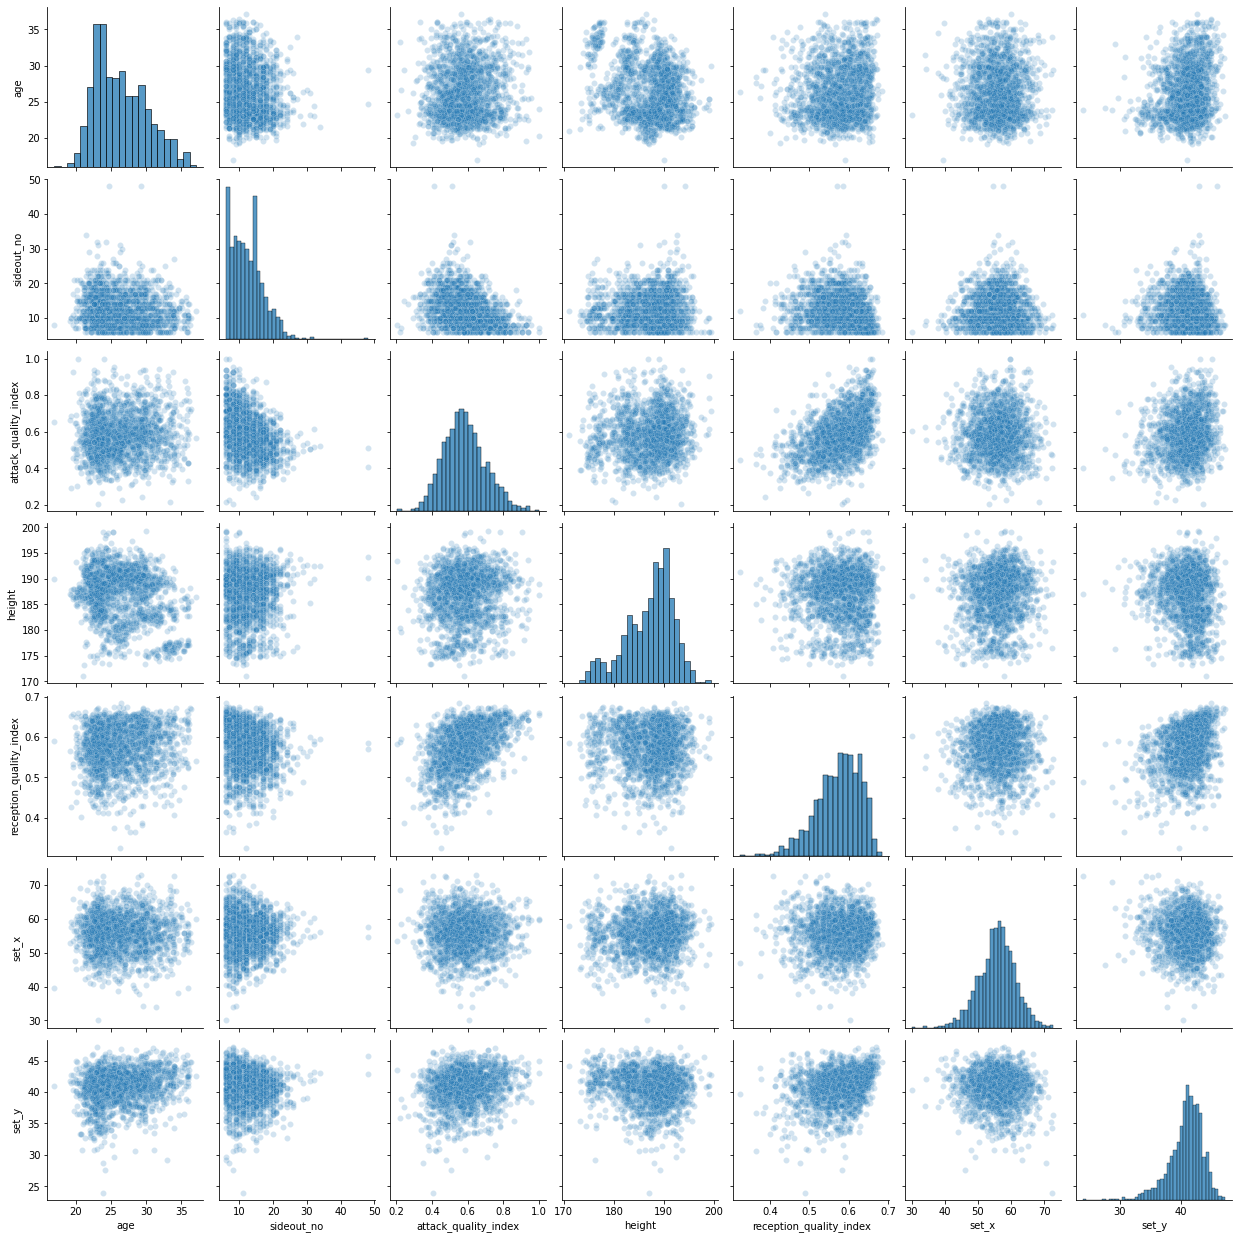

In [172]:
import seaborn as sns
sns.pairplot(aggregation_df.drop(columns='rotation_home'), plot_kws={'alpha':0.2})


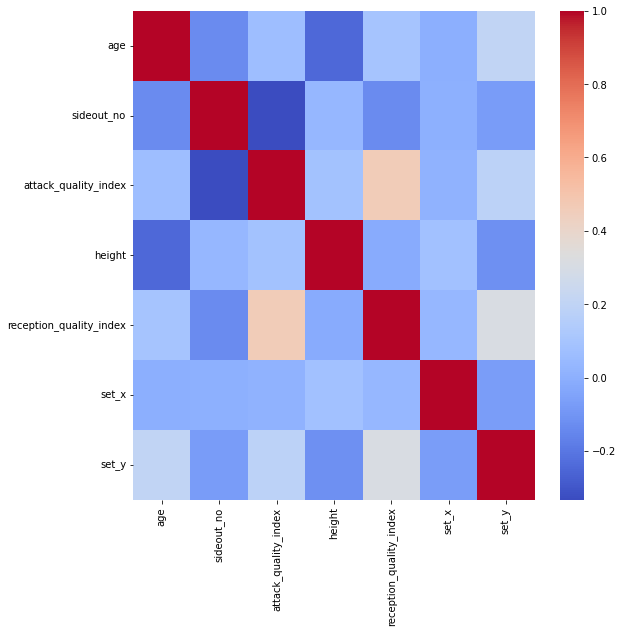

In [173]:
corr = aggregation_df.drop(columns='rotation_home').corr(method='pearson')


import pandas as pd
from seaborn import heatmap
from matplotlib import pyplot as plt

plt.figure(figsize = (9, 9))
heatmap(corr, cmap = 'coolwarm')
plt.show()

In [174]:
print('\n\n\n\nCorrelation values for attack_quality_index:')
display(corr.loc[:,'attack_quality_index'])





Correlation values for attack_quality_index:


age                        0.065940
sideout_no                -0.333451
attack_quality_index       1.000000
                             ...   
reception_quality_index    0.462945
set_x                      0.011145
set_y                      0.182816
Name: attack_quality_index, Length: 7, dtype: float64

In [175]:
ml_df = aggregation_df.copy()

<br><br>

<a id='distributions'></a>

# Numerical variables distribution

I will take a look at how the numerical attributes are distributed in this new aggregated dataset. All the numerical variables will be scaled, and possibly transformed based on their distribution.

Looking at the skew of the distributions, *set_y* appears to be relevantly left-skewed and *sideout_no* right-skewed.

In [176]:
pd.options.display.max_rows = 10
def get_float_shape_stats(df):
    # Create a list of float colums to check for skewing
    cols = ['rotation_home', 'age', 'sideout_no', 'attack_quality_index', 'height', 'reception_quality_index', 'set_x', 'set_y']


    skew_vals = df[cols].skew().reset_index()
    skew_vals.columns = ['column_name', 'Skew']
    kurt_vals = df[cols].kurt().reset_index()
    kurt_vals.columns = ['column_name','Kurtosis']

    summary_shape_df = skew_vals.merge(kurt_vals, how='inner', on='column_name')
    display(summary_shape_df)

get_float_shape_stats(aggregation_df)

,column_name,Skew,Kurtosis
0,rotation_home,-0.037228,-1.293162
1,age,0.553790,-0.441376
2,sideout_no,1.153646,3.642037
3,attack_quality_index,0.315833,0.123301
4,height,-0.643344,-0.005133
5,reception_quality_index,-0.673410,0.295453
6,set_x,-0.262296,0.551881
7,set_y,-0.984498,2.037530


<br><br>

## Sideout_no

Right skewed, it will need a transformation (power transformer).

In [177]:
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline


quantile_transformer = preprocessing.QuantileTransformer(output_distribution='normal', random_state=0)
pt = preprocessing.PowerTransformer(method='box-cox', standardize=True)

log_scale_transformer = make_pipeline(
    preprocessing.FunctionTransformer(np.log1p, validate=False), preprocessing.StandardScaler()
)

sqrt_scale_transformer = make_pipeline(
    preprocessing.FunctionTransformer(np.sqrt, validate=False), preprocessing.StandardScaler()
)


In [178]:

def display_transformations(data, attribute, show_normal_test = True):
    from matplotlib import pyplot as plt
    from scipy.stats.mstats import normaltest
    from sklearn.preprocessing import QuantileTransformer, PowerTransformer, StandardScaler
    from sklearn.pipeline import make_pipeline

    pow_tran = PowerTransformer(method='box-cox', standardize=True)
    quan_tran = QuantileTransformer(output_distribution='normal', random_state=0)

    log_scale_tran = make_pipeline(
        preprocessing.FunctionTransformer(np.log1p, validate=False), preprocessing.StandardScaler()
    )

    sqrt_scale_tran = make_pipeline(
        preprocessing.FunctionTransformer(np.sqrt, validate=False), preprocessing.StandardScaler()
    )

    data[f'{attribute}_transf_PT'] = pow_tran.fit_transform(data[[attribute]])
    data[f'{attribute}_transf_QT'] = quan_tran.fit_transform(data[[attribute]])
    data[f'{attribute}_transf_log1p'] = log_scale_tran.fit_transform(data[[attribute]])
    data[f'{attribute}_transf_sqrt'] = sqrt_scale_tran.fit_transform(data[[attribute]])


    # Create two "subplots" and a "figure" using matplotlib
    fig, (ax_before, ax_after1, ax_after2, ax_after3, ax_after4) = plt.subplots(1, 5, figsize=(15, 5))

    nbins = 15
    # Create a histogram on the "ax_before" subplot
    data[attribute].hist(ax=ax_before, bins=nbins)

    # Apply a log transformation (numpy syntax) to this column
    data[f'{attribute}_transf_PT'].hist(ax=ax_after1, bins=nbins)
    data[f'{attribute}_transf_QT'].hist(ax=ax_after2, bins=nbins)
    data[f'{attribute}_transf_log1p'].hist(ax=ax_after3, bins=nbins)
    data[f'{attribute}_transf_sqrt'].hist(ax=ax_after4, bins=nbins)


    # Formatting of titles etc. for each subplot
    ax_before.set(title='before', ylabel='frequency', xlabel='value')
    ax_after1.set(title='PowerTransformer', ylabel='frequency', xlabel='value')
    ax_after2.set(title='QuantileTransformer', ylabel='frequency', xlabel='value')
    ax_after3.set(title='Log1p', ylabel='frequency', xlabel='value')
    ax_after4.set(title='Sqrt', ylabel='frequency', xlabel='value')
    fig.suptitle(f'{attribute} variable transformation')

    if show_normal_test:
        print('Normal test:\n\n')
        print(f'{attribute}: {normaltest(data[f"{attribute}"].values)}')
        print(f'{attribute}_transf_PT: {normaltest(data[f"{attribute}_transf_PT"].values)}')
        print(f'{attribute}_transf_QT: {normaltest(data[f"{attribute}_transf_QT"].values)}')
        print(f'{attribute}_transf_log1p: {normaltest(data[f"{attribute}_transf_log1p"].values)}')

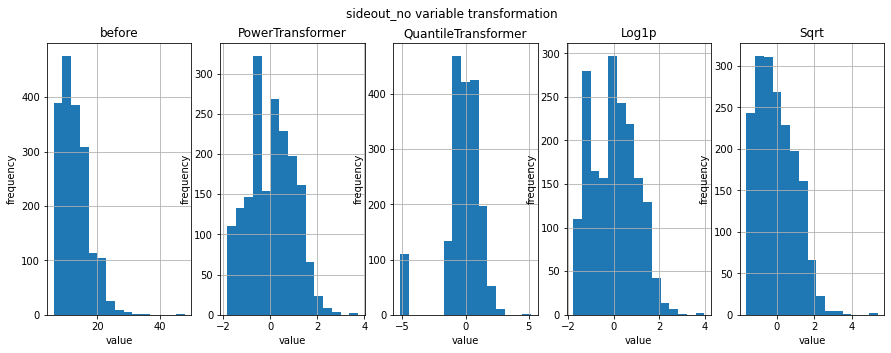

In [179]:
display_transformations(ml_df, 'sideout_no', False)

<br><br>

## attack_quality_index

The distribution looks fairly normal already.


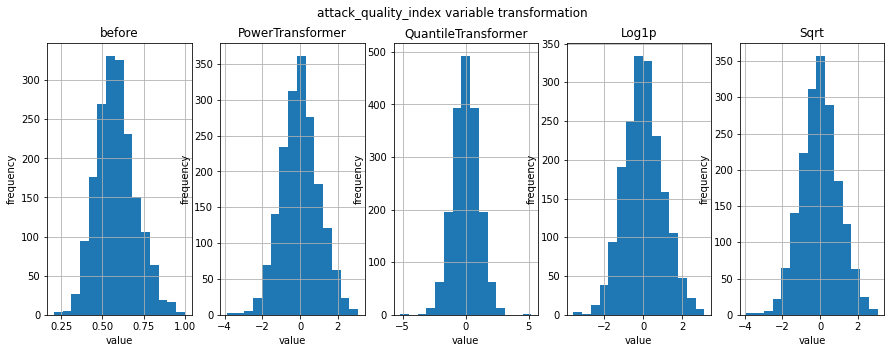

In [180]:
display_transformations(ml_df, 'attack_quality_index', False)

<br><br>

## reception_quality_index


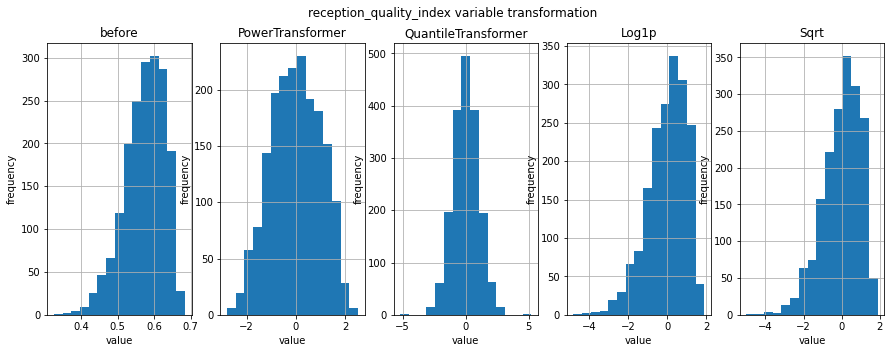

In [181]:
display_transformations(ml_df, 'reception_quality_index', False)


<br><br>

## Age

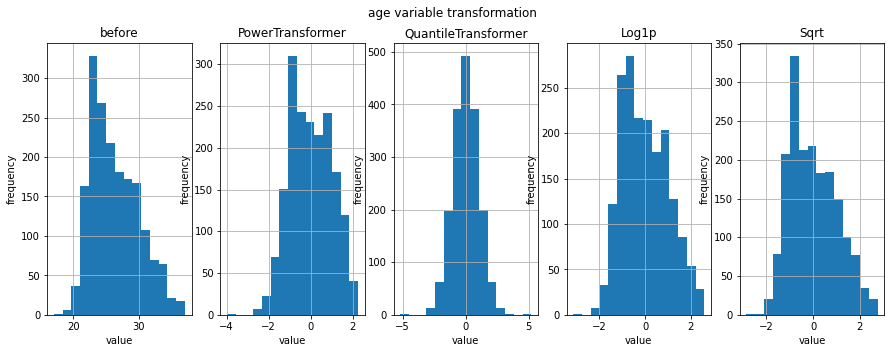

In [182]:
display_transformations(ml_df, 'age', False)


<br><br>

## Height

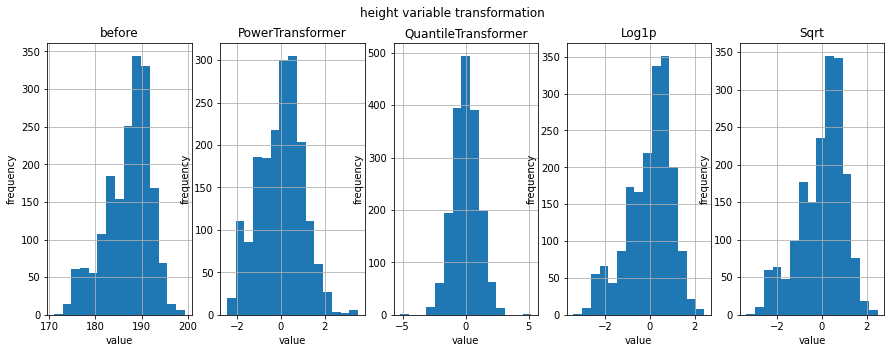

In [183]:
display_transformations(ml_df, 'height', False)



<br><br>

<a id='pipeline'></a>

# Preprocessing pipeline

Apply one-hot encoding to the categorical columns, and box-cox power transformer with normalization to the numerical attributes.

In [184]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, QuantileTransformer, MinMaxScaler

linear_model_preprocessor = ColumnTransformer(
    [
        # ("log_scaled_numeric", log_scale_transformer, ["sideout_no"])
        ("onehot_categorical", OneHotEncoder(),["opponent_team", "rotation_home"]), # "team_name", "date"
        ("power_transformed_numeric", PowerTransformer(method='box-cox', standardize=True) , ["height", "set_x", "set_y", "reception_quality_index", "sideout_no", "age"]),
        # ("quantile_numeric", QuantileTransformer(output_distribution='normal', random_state=42, n_quantiles=300), [])
    ],
    remainder="drop",
)


```python
linear_model_preprocessor = ColumnTransformer(
    [
        ("onehot_categorical", OneHotEncoder(),["opponent_team", "rotation_home"]),
        ("power_transformed_numeric", PowerTransformer(method='box-cox', standardize=True) , ["height", "set_x", "set_y", "reception_quality_index", "sideout_no", "age"]),
    ],
    remainder="drop",
)
```


<br><br>

<a id='split'></a>

# Training-test split

The training-test split is a 80-20. All models will be trained on the same training set (possibly with 10-folds cross validation) and tested on the test set.


<br><br>

<a id='output'></a>

# Output variable processing

Even if the output variable is already between 0.20 and 1.00, I will use a *MinMaxScaler* fit on the training Y to scale both Y_training and Y_test.

In [185]:
from sklearn.model_selection import train_test_split
output = 'attack_quality_index'
X = aggregation_df.drop(columns=output)
Y = aggregation_df[output]



X_train, X_test, Y_train, Y_test = train_test_split(
    X,
    Y,
    test_size=0.20, random_state=42)

output_scaler = MinMaxScaler()
Y_train = pd.Series(output_scaler.fit_transform(Y_train.to_frame())[:,0])
Y_test = pd.Series(output_scaler.transform(Y_test.to_frame())[:,0])


In [234]:
fig = go.Figure(
    data = [
        go.Histogram(x=Y_train, name='Y_train', opacity=0.4),
        go.Histogram(x=Y_test, name='Y_test', opacity=0.4)],
    layout=dict(width=800, barmode='overlay', title='Scaling of output variable', xaxis_title='attack_quality_index_scaled', yaxis_title='frequency')
)
fig.show()


<br><br>

<a id='dummy'></a>

# Dummy predictor

The first predictor will just provide the average value of *attack_quality_index* (scaled) for any value of the input features. Clearly, the linear regression model should beat this dummy model.

In [187]:
from sklearn.dummy import DummyRegressor

from sklearn.pipeline import Pipeline


dummy = Pipeline(
    [
        ("preprocessor", linear_model_preprocessor),
        ("regressor", DummyRegressor(strategy="mean")),
    ]
).fit(X_train, Y_train)


In [188]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_poisson_deviance
from sklearn.metrics import r2_score


output = 'attack_quality_index'

def score_estimator(estimator, x, y):
    """Score an estimator on the test set."""
    y_pred = estimator.predict(x)
    print('Performance evaluated on the test set\n')
    print(
        "Mean Squared Error: %.3f"
        % mean_squared_error(
            y, y_pred
        )
    )
    print(
        "Mean Absolute Error: %.3f"
        % mean_absolute_error(
            y, y_pred
        )
    )
    print(
        "R2 score: %.3f"
        % r2_score(
            y, y_pred
        )
    )

    # Ignore non-positive predictions, as they are invalid for
    # the Poisson deviance.
    mask = y_pred > 0
    if (~mask).any():
        n_masked, n_samples = (~mask).sum(), mask.shape[0]
        print(
            "WARNING: Estimator yields invalid, non-positive predictions "
            f" for {n_masked} samples out of {n_samples}. These predictions "
            "are ignored when computing the Poisson deviance."
        )

    print(
        "mean Poisson deviance: %.3f"
        % mean_poisson_deviance(
            y[mask],
            y_pred[mask],
            # sample_weight=df_test["Exposure"][mask],
        )
    )



Different metrics for model evaluation are provided. I will focus mostly on the R2 score to compare the linear models.

The R2 score for the dummy model is zero, meaning that the model disregards all the input features and just provide an expected value of Y (in this case, the mean value).

In the plot, on the x-axis the model-predicted Y versus the Y_test on the y-axis: If R2 = 1, the plot would be a diagonal line with x values equal to y values.

In the second plot, the residuals on the y-axis are plotted against the real Y_test on the x-axis. Ideally, the points should all lie on the x-axis at y=0.

In [189]:
print("Dummy model evaluation:")
score_estimator(dummy, X_test, Y_test)


Dummy model evaluation:
Performance evaluated on the test set

Mean Squared Error: 0.023
Mean Absolute Error: 0.122
R2 score: -0.002
mean Poisson deviance: 0.050


In [190]:
import plotly.express as px
fig = px.scatter(y=Y_test, x=dummy.predict(X_test), title='Dummy model prediction', width=800)
fig.update_xaxes(title= 'Predicted Y_test')
fig.update_yaxes(title= 'Real Y_test')
fig.show()

In [235]:
fig = go.Figure(
    data=go.Scatter(y=(Y_test-dummy.predict(X_test)), x=Y_test, name='residuals', mode='markers', marker={'color': 'red'}),
    layout=dict(width=800, title='Dummy model residuals', xaxis_title='Real Y_test', yaxis_title='residuals')
)
fig.show()


<br><br>

<a id='vanilla'></a>

# Vanilla linear regression

A simple linear model with no regularization and no cross-validation.

The model clearly outperform the dummy model, but it is still far from reasonable for a reliable model.


In [192]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

vanilla_lr = Pipeline(
    [
        ("preprocessor", linear_model_preprocessor),
        ("regressor", LinearRegression()),
    ]
).fit(X_train,Y_train)


score_estimator(vanilla_lr, X_test, Y_test)

Performance evaluated on the test set

Mean Squared Error: 0.015
Mean Absolute Error: 0.099
R2 score: 0.347
mean Poisson deviance: 0.033


In [237]:
import plotly.express as px
fig = go.Figure(
    data = [
        go.Scatter(y=Y_test, x=vanilla_lr.predict(X_test), mode='markers', name='linear regression outcomes'),
        go.Scatter(x=[0,1], y=[0,1], name='ideal-predictions line', mode='lines')

    ],
    layout=dict(
        title='Vanilla Linear Regression model prediction',
        width=800,
        xaxis_title='Predicted Y_test',
        yaxis_title='Real Y_test',
        xaxis_constrain='domain',
        yaxis_scaleanchor = "x",
        yaxis_scaleratio = 1
    )


)
fig.show()

In [236]:
fig = go.Figure(
    data=go.Scatter(y=(Y_test-vanilla_lr.predict(X_test)), x=Y_test, name='residuals', mode='markers', marker={'color': 'red'}),
    layout=dict(width=800, title='Vanilla LR model residuals', xaxis_title='Real Y_test', yaxis_title='residuals')
)
fig.show()

<br><br>

<a id='features_vanilla'></a>

#<br><br>Important features from Vanilla linear regressor

We can take a look at which features are more important in predicting the outcome of a sideout attack.

The major factors promoting a positive attack outcome are higher quality reception, and playing against Italy and Thailand.
On the other hand, having to attack more and more during a set/game is unfavorable for attack performance. Additionally, playing against Team USA seems to be a major disruption to sideout attack performance. Setter rotation 2 seems to be unfavorable as well.

As the model presents large errors and it is not very accurate, I would not take these results too much at heart, however they appear to give interesting insights, as it is expected to have better sideout attacks with better reception quality, and Thailand is generally a team with shorter players, so playing against Thailand definitely improves sideout performance.

One tricky consideration lies behind the number of sideout attacks in a set/game: having low sideout efficiency means the team will be 'stuck' in a rotation, and forced to perform more and more sideout attacks. Hence, it is not a high sideout attack count that results in lower attack performance, but the opposite (lower attack performance causes a higher sideout_no count).

A surprising result is high sideout efficiency associated with playing against Team Italy (a strong team). Once again, I would not put too much trust behind this, but definitely something to look at more carefully.


In [195]:
pd.options.display.max_rows = 6
pd.set_option('display.width', None)
df_importances = pd.DataFrame(
    data={
        'feature': vanilla_lr.named_steps["preprocessor"].get_feature_names_out(),
        'importance': vanilla_lr.named_steps["regressor"].coef_,
    }
)

display(df_importances.sort_values(by='importance'))

,feature,importance
28,power_transformed_numeric__sideout_no,-0.048283
17,onehot_categorical__opponent_team_United States of America,-0.028006
19,onehot_categorical__rotation_home_2,-0.026351
...,...,...
15,onehot_categorical__opponent_team_Thailand,0.025703
7,onehot_categorical__opponent_team_Italy,0.036492
27,power_transformed_numeric__reception_quality_index,0.059750


<br><br>

<a id='kfold'></a>

## k-fold validation for vanilla linear regressor

A k-fold validation will provide a less optimistic but more realistic benchmark for the prediction performance of the model on unseen data.

In [196]:
from sklearn.model_selection import KFold, cross_val_predict, cross_val_score

kf = KFold(shuffle=True, random_state=42, n_splits=10)

scores = cross_val_score(vanilla_lr, X, Y, cv=kf, scoring='r2')
print(f"Number of folds: {kf.n_splits}\nR2 score: {scores.mean():.3f} with a standard deviation of {scores.std():.2f}")



Number of folds: 10
R2 score: 0.314 with a standard deviation of 0.04


<br><br>

<a id='poly'></a>

## Polynomial features

Adding polynomial features might improve performance of the model. In this case, it does not help at all.

In [197]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

lr_poly = Pipeline(
    [
        ("preprocessor", linear_model_preprocessor),
        ("make_higher_degree", PolynomialFeatures(degree=2)),
        ("regressor", LinearRegression()),
    ]
).fit(X_train, Y_train)

score_estimator(lr_poly, X_test, Y_test)


Performance evaluated on the test set

Mean Squared Error: 0.019
Mean Absolute Error: 0.110
R2 score: 0.185
mean Poisson deviance: 0.042


In [198]:
import plotly.express as px
fig = px.scatter(y=Y_test, x=lr_poly.predict(X_test), title='2nd Order Poly LR model prediction', width=800)
fig.add_trace(go.Scatter(x=[0,1], y=[0,1], name='ideal-predictions line', mode='lines'))
fig.update_xaxes(title= 'Predicted Y_test')
fig.update_yaxes(title= 'Real Y_test')
fig.update_xaxes(constrain='domain')
fig.update_yaxes(scaleanchor = "x", scaleratio = 1)
fig.show()


<br><br>

<a id='interactions'></a>

## Polynomial features (only interaction terms)

Using the *interaction_only*, it is possible to investigate the interaction beetween first order features.

The model performs better than a second order polynomial model, but it is still outperformed by simple linear regression.

We could in principle look at the importance of all features and their relationship, but as the model performance is poor, I would not delve into that analysis.

In [199]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

lr_poly = Pipeline(
    [
        ("preprocessor", linear_model_preprocessor),
        ("make_higher_degree", PolynomialFeatures(degree=2, interaction_only=True)),
        ("regressor", LinearRegression()),
    ]
).fit(X_train, Y_train)

score_estimator(lr_poly, X_test, Y_test)


Performance evaluated on the test set

Mean Squared Error: 0.019
Mean Absolute Error: 0.109
R2 score: 0.188
mean Poisson deviance: 0.042


In [200]:
pd.set_option('display.max_colwidth', None)
df_importances = pd.DataFrame(
    data={
        'feature_name': lr_poly.named_steps["make_higher_degree"].get_feature_names_out(lr_poly.named_steps["preprocessor"].get_feature_names_out()),
        'importance': lr_poly.named_steps["regressor"].coef_
    }
)

col_names_dict = dict(zip(list(range(len(X_test.columns.values))), X_test.columns.values))

# display(col_names_dict)
display(df_importances.sort_values(by='importance'))

,feature_name,importance
266,onehot_categorical__opponent_team_Kenya onehot_categorical__rotation_home_3,-0.149302
76,onehot_categorical__opponent_team_Belgium onehot_categorical__rotation_home_1,-0.111379
52,onehot_categorical__opponent_team_Argentina onehot_categorical__rotation_home_5,-0.102367
...,...,...
204,onehot_categorical__opponent_team_Germany onehot_categorical__rotation_home_4,0.087424
48,onehot_categorical__opponent_team_Argentina onehot_categorical__rotation_home_1,0.103550
59,onehot_categorical__opponent_team_Argentina power_transformed_numeric__age,0.108728


<br><br>

<a id='ridge'></a>

# Ridge, with GridSearchCV

Introduce a L2-regularized linear model with Ridge, cross-validated on 10 folds and evaluated on the test set.

Using GridSearchCV I am able to test different configurations of the hyperparameter $\alpha$ and polynomial features.

It has better performance than the vanilla linear regression (as seen in the kFold validation test).

The parameters importance order is largely unaltered when compared to the vanilla linear regression.

```python

kf = KFold(shuffle=True, random_state=42, n_splits=10)

estimator = Pipeline([
        ("preprocessor", linear_model_preprocessor),
        ("polynomial_features", PolynomialFeatures()),
        ("ridge_regression", Ridge())])

params = {
    'polynomial_features__degree': [1, 2],
    'polynomial_features__interaction_only': [True, False],
    'ridge_regression__alpha': np.geomspace(1, 100, 20)
}

ridge_lr = GridSearchCV(estimator, params, cv=kf)
```


In [201]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge


kf = KFold(shuffle=True, random_state=42, n_splits=10)

# Same estimator as before
estimator = Pipeline([
        ("preprocessor", linear_model_preprocessor),
        ("polynomial_features", PolynomialFeatures()),
        ("ridge_regression", Ridge())])

params = {
    'polynomial_features__degree': [1, 2],
    'polynomial_features__interaction_only': [True, False],
    'ridge_regression__alpha': np.geomspace(1, 100, 20)
}

ridge_lr = GridSearchCV(estimator, params, cv=kf)

In [202]:
result = ridge_lr.fit(X_train, Y_train)

In [203]:
print(f'Ridge\nBest score: {ridge_lr.best_score_:.3f}, Best params: {ridge_lr.best_params_}\n\n\n')

y_predict = ridge_lr.predict(X_test)
score_estimator(ridge_lr, X_test, Y_test)


print(f'\n\nOf {len(ridge_lr.best_estimator_.named_steps["ridge_regression"].coef_)} coefficients, {len(ridge_lr.best_estimator_.named_steps["ridge_regression"].coef_.nonzero()[0])} are non-zero with Ridge.')


Ridge
Best score: 0.304, Best params: {'polynomial_features__degree': 1, 'polynomial_features__interaction_only': True, 'ridge_regression__alpha': 61.584821106602604}



Performance evaluated on the test set

Mean Squared Error: 0.015
Mean Absolute Error: 0.099
R2 score: 0.346
mean Poisson deviance: 0.033


Of 31 coefficients, 31 are non-zero with Ridge.


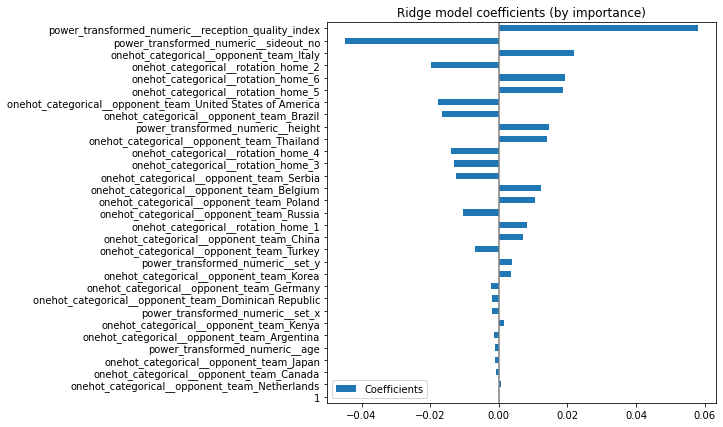

In [204]:
coefs = pd.DataFrame(
    ridge_lr.best_estimator_.named_steps['ridge_regression'].coef_,
    columns=["Coefficients"],
    index=ridge_lr.best_estimator_.named_steps["polynomial_features"].get_feature_names_out(ridge_lr.best_estimator_.named_steps["preprocessor"].get_feature_names_out()),
).sort_values(by='Coefficients', ascending=True, key=abs)
coefs.plot(kind="barh", figsize=(9, 7))
plt.title("Ridge model coefficients (by importance)")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)



In [205]:

import plotly.express as px
fig = px.scatter(y=Y_test, x=ridge_lr.best_estimator_.predict(X_test), title='Ridge LR prediction', width=800)
fig.add_trace(go.Scatter(x=[0,1], y=[0,1], name='ideal-predictions line', mode='lines'))
fig.update_xaxes(title= 'Predicted Y_test')
fig.update_yaxes(title= 'Real Y_test')
fig.update_xaxes(constrain='domain')
fig.update_yaxes(scaleanchor = "x", scaleratio = 1)
fig.show()


<br><br>

<a id='lasso'></a>

# Lasso, with GridSearchCV

The performance with L1 regularization is very similar to Ridge, with the advantage of reducing the model to 23 parameters.

The order of importance of the parameters is very similar to Ridge as well.

```python
kf = KFold(shuffle=True, random_state=42, n_splits=10)

estimator = Pipeline([
        ("preprocessor", linear_model_preprocessor),
        ("polynomial_features", PolynomialFeatures()),
        ("lasso_regression", Lasso(max_iter=10000, tol=5e-3))])

params = {
    'polynomial_features__degree': [1, 2],
    'lasso_regression__alpha': np.geomspace(1e-4, 5e0, num=15)
}

lasso_lr = GridSearchCV(estimator, params, cv=kf)
```

In [206]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso

kf = KFold(shuffle=True, random_state=42, n_splits=10)

estimator = Pipeline([
        ("preprocessor", linear_model_preprocessor),
        ("polynomial_features", PolynomialFeatures()),
        ("lasso_regression", Lasso(max_iter=10000, tol=5e-3))])

params = {
    'polynomial_features__degree': [1, 2],
    'lasso_regression__alpha': np.geomspace(1e-4, 5e0, num=15)
}

lasso_lr = GridSearchCV(estimator, params, cv=kf)

In [207]:
result = lasso_lr.fit(X_train, Y_train)

In [208]:
print(f'Lasso\nBest score: {lasso_lr.best_score_:.3f}, Best params: {lasso_lr.best_params_}\n\n\n')


y_predict = lasso_lr.predict(X_test)
score_estimator(lasso_lr, X_test, Y_test)


print(f'\n\nOf {len(lasso_lr.best_estimator_.named_steps["lasso_regression"].coef_)} coefficients, {len(lasso_lr.best_estimator_.named_steps["lasso_regression"].coef_.nonzero()[0])} are non-zero with Lasso.')


Lasso
Best score: 0.304, Best params: {'lasso_regression__alpha': 0.00046911727854354144, 'polynomial_features__degree': 1}



Performance evaluated on the test set

Mean Squared Error: 0.015
Mean Absolute Error: 0.099
R2 score: 0.346
mean Poisson deviance: 0.033


Of 31 coefficients, 21 are non-zero with Lasso.


In [209]:
import plotly.express as px
fig = px.scatter(y=Y_test, x=lasso_lr.best_estimator_.predict(X_test), title='Lasso LR prediction', width=800)
fig.add_trace(go.Scatter(x=[0,1], y=[0,1], name='ideal-predictions line', mode='lines'))
fig.update_xaxes(title= 'Predicted Y_test')
fig.update_yaxes(title= 'Real Y_test')
fig.update_xaxes(constrain='domain')
fig.update_yaxes(scaleanchor = "x", scaleratio = 1)
fig.show()


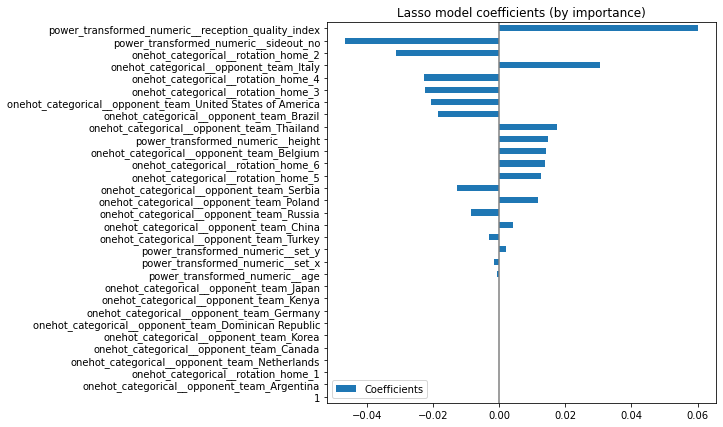

In [210]:
coefs = pd.DataFrame(
    lasso_lr.best_estimator_.named_steps['lasso_regression'].coef_,
    columns=["Coefficients"],
    index=lasso_lr.best_estimator_.named_steps["polynomial_features"].get_feature_names_out(lasso_lr.best_estimator_.named_steps["preprocessor"].get_feature_names_out()),
).sort_values(by='Coefficients', ascending=True, key=abs)
coefs.plot(kind="barh", figsize=(9, 7))
plt.title("Lasso model coefficients (by importance)")
plt.axvline(x=0, color=".5")
plt.subplots_adjust(left=0.3)


In [211]:
pd.set_option('display.max_colwidth', None)
pd.DataFrame(
    data={
        'feature': lasso_lr.best_estimator_.named_steps["polynomial_features"].get_feature_names_out(lr_poly.named_steps["preprocessor"].get_feature_names_out()),
        'importance': lasso_lr.best_estimator_.named_steps['lasso_regression'].coef_}).sort_values(by='importance')


,feature,importance
29,power_transformed_numeric__sideout_no,-0.046661
20,onehot_categorical__rotation_home_2,-0.031057
22,onehot_categorical__rotation_home_4,-0.022753
...,...,...
16,onehot_categorical__opponent_team_Thailand,0.017396
8,onehot_categorical__opponent_team_Italy,0.030558
28,power_transformed_numeric__reception_quality_index,0.060220


<br><br>

<a id='elastic'></a>

# ElasticNet, with GridSearchCV

ElasticNet combines both Ridge and Lasso penalties, controlling the ratio between L1 and L2 penalties, with l1_ratio = 1 being equivalent to Lasso penalty.

As both Ridge and Lasso models obtained the best results with no polynomial features, the ElasticNet setup included only first order features.

The model best result was obtained with l1_ratio = 0.1 (the lowest provided), prioritizing the L2 penalty.

The value of $\alpha$ is small, indicating only a limited regularization needed.


In [212]:

from sklearn.linear_model import ElasticNetCV, ElasticNet

l1_ratios = np.linspace(0.1, 0.9, 9)
kf = KFold(shuffle=True, random_state=42, n_splits=10)

estimator = Pipeline([
        ("preprocessor", linear_model_preprocessor),
        ("polynomial_features", PolynomialFeatures()),
        ("elastic_net", ElasticNet(max_iter=10000, tol=5e-3))])

params = {
    'polynomial_features__degree': [1],
    # 'polynomial_features__interaction_only': [True, False],
    'elastic_net__alpha': np.geomspace(1e-4, 5e0, num=15),
    'elastic_net__l1_ratio': l1_ratios
}

elastic_lr = GridSearchCV(estimator, params, cv=kf)
result = elastic_lr.fit(X_train, Y_train)

In [213]:
# print(elastic_lr.best_estimator_.named_steps['elastic_net'].coef_)
print(f'Best ElasticNet estimator\nalpha={elastic_lr.best_estimator_.named_steps["elastic_net"].alpha:.6f}, l1_ratio={elastic_lr.best_estimator_.named_steps["elastic_net"].l1_ratio:.2f}')

print(f'ElasticNet\nBest score: {elastic_lr.best_score_:.3f}, Best params: {elastic_lr.best_params_}\n\n\n')


y_predict = elastic_lr.predict(X_test)
score_estimator(elastic_lr, X_test, Y_test)

print(f'\n\nOf {len(elastic_lr.best_estimator_.named_steps["elastic_net"].coef_)} coefficients, {len(elastic_lr.best_estimator_.named_steps["elastic_net"].coef_.nonzero()[0])} are non-zero with ElasticNet.')

Best ElasticNet estimator
alpha=0.004767, l1_ratio=0.10
ElasticNet
Best score: 0.304, Best params: {'elastic_net__alpha': 0.004766543633698726, 'elastic_net__l1_ratio': 0.1, 'polynomial_features__degree': 1}



Performance evaluated on the test set

Mean Squared Error: 0.015
Mean Absolute Error: 0.099
R2 score: 0.346
mean Poisson deviance: 0.033


Of 31 coefficients, 22 are non-zero with ElasticNet.


In [214]:
import plotly.express as px
fig = px.scatter(y=Y_test, x=elastic_lr.predict(X_test), title='ElasticNet prediction', width=800)
fig.add_trace(go.Scatter(x=[0,1], y=[0,1], name='ideal-predictions line', mode='lines'))
fig.update_xaxes(title= 'Predicted Y_test')
fig.update_yaxes(title= 'Real Y_test')
fig.update_xaxes(constrain='domain')
fig.update_yaxes(scaleanchor = "x", scaleratio = 1)
fig.show()


<br><br>

<a id='residuals'></a>

# Visualization of residual distributions

I expect the residuals to be normally distributed (verified) for the linear model to be valid.

All models performed significantly better than the dummy model, however the difference between all linear regression models is limited in this case in exam.


In [215]:
error_dummy = Y_test - dummy.predict(X_test)
error_vanilla = Y_test - vanilla_lr.predict(X_test )
error_ridge = Y_test - ridge_lr.predict(X_test )
error_lasso = Y_test - lasso_lr.predict(X_test )
error_elastic = Y_test - elastic_lr.predict(X_test )

errors_df = pd.DataFrame(data={'x': Y_test, 'dummy': error_dummy, 'vanilla': error_vanilla, 'ridge': error_ridge,
                               'lasso': error_lasso, 'elastic': error_elastic})

In [216]:
# fig = go.Figure()
# fig.add_trace(go.Histogram(x=errors_df.dummy, name='dummy', nbinsx=50))
# fig.add_trace(go.Histogram(x=errors_df.vanilla, name='vanilla', nbinsx=50))
#
# # Overlay both histograms
# fig.update_layout(barmode='overlay', title='Residuals for dummy model vs. vanilla linear regression')
# # Reduce opacity to see both histograms
#
# fig.update_traces(opacity=0.8)
# fig.show()



In [233]:
fig= go.Figure(
   data = [
       go.Histogram(x=errors_df.vanilla, name='vanilla', nbinsx=50, opacity=0.4),
       go.Histogram(x=errors_df.ridge, name='ridge', nbinsx=50, opacity=0.4),
       go.Histogram(x=errors_df.lasso, name='lasso', nbinsx=50, opacity=0.4),
       go.Histogram(x=errors_df.elastic, name='elastic', nbinsx=50, opacity=0.4)
   ],
   layout=dict(width=800, barmode='overlay', title='Linear regression model residuals comparison', xaxis_title='Real Y_test', yaxis_title='residuals')
)

fig.show()

<br><br>

<a id='summary'></a>

# Summary of the trained models

- Dummy linear regression
- Linear regression
- Linear regression with 10-folds cross-validation
- Linear regression with polynomial features
- Linear regression of second order with only interaction terms
- Ridge (10-folds validation, test on polynomial features degree 1 and 2, only interaction term True/False, $\alpha$ 0 to 100)
- Lasso (10-folds validation, test on polynomial features degree 1 and 2, $\alpha=$ 0.0001 to 5)
- ElasticNet (10-folds validation, $\alpha=$ 0.0001 to 5, l1_ratio 0.1 to 0.9)

<br><br>

<a id='modelchoice'></a>

# Model selection

As **interpretation** was the main goal of this analysis, Lasso offers the advantage of a simplified model. However, given that the best estimator $\alpha$ value is small (little regularization needed) and that the l1_ratio in ElasticNet favors the L2 penalty, **Ridge** is the suggested model for this dataset.

Ridge advantages:
- Much faster convergence
- It did not encounter convergence problems
- It captured as efficiently as Lasso the important parameters determining the outcome (*attack_quality_index*)

Ridge disadvantages:
- It cannot offer a simplified model

Considering that the model included only 31 features (as polynomial features were not effective in aiding the model performance), it is reasonable to work with Ridge full scale model, while avoiding the convergence hassle encountered training Lasso.


<br><br>

<a id='keyfindings'></a>

# Key Findings summary

The most important factors in determining sideout attack efficiency (according to the Ridge linear regression) are here listed.

- The most important parameters *promoting* a higher sideout attack efficiency:
> 1. *reception_quality_index*
> 2. *opponent_team* is Italy
> 3. *rotation_home* is 6

- The most important parameters *hindering* sideout attack efficiency:
> 1. *rotation_home* is 2
> 2. *opponent_team* is USA
> 3. *opponent_team* is Brazil

IMPORTANT: *sideout_no* is related to the *attack_quality_index*. However, it is the *attack_quality_index* that has an effect on *sideout_no*, not vice-versa. It is important in this case not to confuse the cause (low *attack_quality_index*) with the effect (higher *sideout_no*).

One of the three *promoting* factors is surprising: Team Italy is a strong team, so it is hard to imagine that it could promote a better sideout efficiency. It is possible that since Team ITA played one competition with their youth team, the corresponding records are impacting this result.

Setter position (*rotation_home*) plays an important role, as rotation 6 (three attackers available in their best position) promotes higher attack efficiency, and rotation 2 (two attackers, in their least favorable positions) obstruct it.

Opponent teams are important as well, with USA and Brazil (1st and 2nd place at 2020 Tokyo Olympics) leading to the worst sideout outcomes for all other teams.

<br><br>

<a id='conclusions'></a>

# Conclusions

- The linear model for this analysis is not predictive to a sufficient degree. There is no clear linear relationship to be investigated
- With this linear model, we are still able to capture the importance of few attributes on the *attack_quality_index* outcome
- The most important parameters are: *reception_quality_index* (+), *rotation_home* is 2 (-), *opponent_team* is Italy (+)
- *sideout_no* is related to the *attack_quality_index*, but it is the *attack_quality_index* that has an effect on *sideout_no*, not viceversa (as the model seems to suggest)
- Linear regressions with regularization all performed very similarly, all performing marginally better than vanilla linear regression
- Lasso and ElasticNet took considerable time to run, and required particular attention in the choice of the parameters in order to reach convergence
- The requisites for linear regression (no heteroskedacity, no multi-colinearity, no auto-correlation) were all respected
- Categorical variables were encoded with one-hot encoding, numerical variables were transformed with box-cox power transformation and scaled before the linear mode

<br><br>

<a id='future'></a>

# Future plans and suggestions

This dataset is not very suitable for linear models application. It is likely that regression models targeting *classification* and decision trees will lead to more meaningful insight into the data.


In [218]:
# pivot_index = ['attack_player', 'date']
#
# ml_df = pd.pivot_table(
#     df_clear,
#     index=pivot_index,
#     # columns='IsSideoutPoint',
#     values=['IsSideoutPoint'],
#     aggfunc={
#         'IsSideoutPoint': ['mean', 'count']
#     },
#     observed=True
# ).reset_index()
#
# ml_df = ml_df.rename(columns={'mean': 'atk_avg', 'count': 'atk_no'})
# ml_df.columns = ['attack_player', 'date', 'atk_no', 'atk_avg']
# ml_df = ml_df[ml_df.attack_player != 'No Attacker']
# ml_df = ml_df[ml_df.atk_no > 3]
#
# display(ml_df.sort_values(by='atk_no', ascending=False))